# Document Classification
- [Import Libraries](#libs)
- [Read/Preprocess Text](#prep)
- [Greek pretrained skipgram embeddings](#embeds)
- [CNN](#cnn)
- [Feature Engineering](#fe)
 - [tf-idf](#tfidf)
 - [lsa/lsi with tsvd](#tsvd)
 - [bm25](#bm25)
- [MLP/XGB/SVM on generated features](#mlp)
- [Graph Kernel-Weisfeiler-Lehman](#gk)

### Import libraries <a id='libs'></a>

In [1]:
# !python -m spacy download el_core_news_sm
# !python -m spacy download el_core_news_md
from __future__ import print_function
print(__doc__)
import re

import el_core_news_md
nlp = el_core_news_md.load()
nlp.remove_pipe('ner')
nlp.max_length = 93621305
%load_ext autoreload
%autoreload 2

import os
import zipfile
from tqdm import tqdm
import pickle
import numpy as np
import csv 
import gc
import sys

import keras
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Conv1D,GlobalMaxPooling1D
from keras.layers import Dropout,Dense,Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import load_model
from keras import backend as K

import multiprocessing
import platform
import psutil
from tensorflow.python.client import device_lib
from tensorflow import set_random_seed

import networkx as nx

from random import randint
from gensim.models import Word2Vec
sys.path.insert(0,'C:/Users/User/Desktop/DS_challenge/')
from GraphEmbedding.ge import DeepWalk

import sklearn as sk
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import hstack
from scipy.sparse import coo_matrix

import seaborn as sn
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf
import gensim
import seaborn as sns
import time

from grakel.kernels import WeisfeilerLehman, VertexHistogram
from grakel import Graph
from grakel import GraphKernel

from tqdm import tqdm

import nltk
from nltk import word_tokenize
from nltk.corpus import sentence_polarity
# nltk.download('sentence_polarity') 

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Gensim {gensim.__version__}")
print(f"Seaborn {sns.__version__}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

p = platform.processor()
mem = psutil.virtual_memory()

print(f'Your CPU is: {p}')
print(f'Your CPU has {multiprocessing.cpu_count()} cores.')
print(f'Total memory: {sizeof_fmt(mem.total)}')
print(mem)

local_device_protos = device_lib.list_local_devices()
gpuList = [x for x in local_device_protos if x.device_type == 'GPU']

print("Installed GPUs:")
for x in gpuList:
    print("{} - {}".format(x.name,x.physical_device_desc))
%matplotlib inline

Automatically created module for IPython interactive environment


Using TensorFlow backend.


Tensor Flow Version: 1.12.0
Keras Version: 2.2.4

Python 3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]
Gensim 3.7.3
Seaborn 0.9.0
Pandas 0.24.1
Scikit-Learn 0.20.2
Your CPU is: Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
Your CPU has 8 cores.
Total memory: 15.9GiB
svmem(total=17034620928, available=7013130240, percent=58.8, used=10021490688, free=7013130240)
Installed GPUs:
/device:GPU:0 - device: 0, name: GeForce GTX 960M, pci bus id: 0000:01:00.0, compute capability: 5.0


### Load Data and Preprocess <a id='prep'></a>

In [2]:
dir_path = r'C:\Users\User\Desktop\DS_challenge\data\\'
TRAIN_FILE = dir_path + "train.csv"
TEST_FILE = dir_path + "test.csv"
GRAPH_FILE = dir_path + "edgelist.txt"
domains_path = 'C:/Users/User/Desktop/DS_challenge/data/data_science_challenge_2019/domains/'

class_labels = {'athlitismos':0, 'diaskedasi-psyxagogia':1, 'eidiseis-mme':2, 'katastimata-agores':3, 'pliroforiki-diadiktyo':4}

train_hosts = list()
train_labels = list()
with open(TRAIN_FILE, 'r') as f:
    for line in f:
        l = line.split(',')
        train_hosts.append(l[0])
        train_labels.append(l[1][:-1])

y_train_class = []
y_train_dum = np.zeros((len(train_hosts), len(class_labels)))
for i, train_label in enumerate(train_labels):
    y_train_dum[i,class_labels[train_label]] = 1
    y_train_class.append(class_labels[train_label])

test_hosts = list()
with open(TEST_FILE, 'r') as f:
    for line in f:
        l = line.split(',')
        test_hosts.append(l[0])

text = dict()
filenames = os.listdir(domains_path)
for filename in filenames:
    if filename[-4:] == '.zip':
        z = zipfile.ZipFile(domains_path + filename)
        contents = z.namelist()
        #text[filename[:-4]] = [] 
        text_list = []
        for c in contents:
            f = z.open(c)
            data = f.read()
            text_list.append(data.decode('utf16')) #for windows: latin1
            f.close()
        text[filename[:-4]] = text_list
            
# Read webpages of the training set
train_data = list()
for host in train_hosts:
    if host in text:
        train_data.append(text[host])
    else:
        train_data.append('')

# Read webpages of the test set
test_data = list()
for host in test_hosts:
    if host in text:
        test_data.append(text[host])
    else:
        test_data.append('')
        
del text

We preprocess all the texts.
- remove special symbols letters
- transform to lower case
- remove links etc.
- lemmatize the tokens as an option

In [5]:
def clean_str(string, lemma=True):
    string = re.sub(r'^https?:\/\/.*[\r\n]*', '', string, flags=re.MULTILINE)
    string = string.lower()
    string = re.sub(r"[^άέήίόύώα-ωa-z0-9(),!?\'\`]", " ", string)     
    string = re.sub(r"\'s", " \'s", string) 
    string = re.sub(r"\'ve", " \'ve", string) 
    string = re.sub(r"n\'t", " n\'t", string) 
    string = re.sub(r"\'re", " \'re", string) 
    string = re.sub(r"\'d", " \'d", string) 
    string = re.sub(r"\'ll", " \'ll", string) 
    string = re.sub(r",", " , ", string) 
    string = re.sub(r"!", " ! ", string) 
    string = re.sub(r"\(", " \( ", string) 
    string = re.sub(r"\)", " \) ", string) 
    string = re.sub(r"\?", " \? ", string) 
    string = re.sub(r"\s{2,}", " ", string)
    if lemma==True:
        string = nlp(string)
        string = [token.lemma_ for token in string ] #if ('\n' not in token.lemma_)]
    else:
        string = string.strip().split()        
    return string

We apply this preprocessing function to each document and we store the results to pickle objects so we do not have to rerun it each time.
<br>
We create 3 different types of tokenized documents.
- 5000 lemmatized tokens equally sampled from or urls of a website(in order to use it in CNNs)
- full text lemmatized tokens
- full text without lemmatizing

In [6]:
'''
serialized_docs_dir = 'C:/Users/User/Desktop/DS_challenge/data/serialized_objects/'

max_size = 5000
for i in tqdm(range(len(train_data))):
    num_urls = len(train_data[i])       
    
    doc_clean = []
    doc_concat = []
    if num_urls != 0:
        num_tokens_per_url = int(max_size/num_urls)
        
        for url in train_data[i]:
            doc_clean.append(clean_str(url, lemma=False))
            
        remain_tokens = 0
        max_doc_len_id = -1
        max_length = 0
        for idx, d in enumerate(doc_clean):  
            if len(d)>max_length:
                max_length = len(d)
                max_doc_len_id = idx
                
            if len(d) > (num_tokens_per_url + remain_tokens):
                n_tok = remain_tokens + num_tokens_per_url
                doc_concat += d[:n_tok]
                remain_tokens = 0
            else:
                remain_tokens += (num_tokens_per_url - len(d))
                doc_concat += d
        try:
            more_tokens = (max_size - len(doc_concat))
            doc_concat += doc_clean[max_doc_len_id][-more_tokens:]
        except:
            pass
            
    # All tokens
    doc_dict = {
        'y': y_train_dum[i],
        'x_list': doc_concat
    } 
    pickle_out = open(serialized_docs_dir + 'train_mix/' + 'dict.pickle_' + str(i), "wb")
    pickle.dump(doc_dict, pickle_out)
    pickle_out.close()
    
for i in tqdm(range(len(test_data))):
    num_urls = len(test_data[i])       
    
    doc_clean = []
    doc_concat = []
    if num_urls != 0:
        num_tokens_per_url = int(max_size/num_urls)
        
        for url in test_data[i]:
            doc_clean.append(clean_str(url, lemma=False))
        
        remain_tokens = 0
        max_doc_len_id = -1
        max_length = 0
        for idx, d in enumerate(doc_clean):  
            if len(d)>max_length:
                max_length = len(d)
                max_doc_len_id = idx
                
            if (len(d)) > (num_tokens_per_url + remain_tokens):
                n_tok = remain_tokens + num_tokens_per_url
                doc_concat += d[:n_tok]
                remain_tokens = 0
            else:
                remain_tokens += (num_tokens_per_url - len(d))
                doc_concat += d
        try:
            more_tokens = (max_size - len(doc_concat))
            doc_concat += doc_clean[max_doc_len_id][-more_tokens:]            
        except:
            pass
            

    # All tokens
    doc_dict = {        
        'x_list': doc_concat
    } 
    pickle_out = open(serialized_docs_dir + 'test_mix/' + 'dict.pickle_' + str(i), "wb")
    pickle.dump(doc_dict, pickle_out)
    pickle_out.close()

for i in tqdm(range(len(train_data))):    
    doc_concat = []
    for url in train_data[i]:
        doc_concat += clean_str(url, lemma=False)
    #d_lemma = clean_str(train_data[i], lemma=True)  
    
    # All tokens
    doc_dict = {
        'y': y_train_dum[i],
        'x_list': doc_concat
    } 
    pickle_out = open(serialized_docs_dir + 'train_all/' + 'dict.pickle_' + str(i), "wb")
    pickle.dump(doc_dict, pickle_out)
    pickle_out.close()
    
    # All tokens lemma
    #doc_dict_lemma = {
    #    'y': y_train[i],
    #    'x_list': d_lemma
    #} 
    #pickle_out = open(serialized_docs_dir + 'train_all_lemma/' + 'dict.pickle_' + str(i), "wb")
    #pickle.dump(doc_dict_lemma, pickle_out)
    #pickle_out.close()
    
    # First 5000 tokens no lemma
    #if len(d_lemma) > 5000:
    #    doc_dict_lemma_5000 = {
    #        'y': y_train[i],
    #        'x_list': d_lemma[:5000]
    #    } 
    #else:
    #    doc_dict_lemma_5000 = {
    #        'y': y_train[i],
    #        'x_list': d_lemma
    #    }    
    
    #pickle_out = open(serialized_docs_dir + 'train/' + 'dict.pickle_' + str(i), "wb")
    #pickle.dump(doc_dict_lemma_5000, pickle_out)
    #pickle_out.close()

# Same for the test documents
for i in tqdm(range(len(test_data))):
    doc_concat = []
    for url in test_data[i]:
        doc_concat += clean_str(url, lemma=False)
    #d_lemma = clean_str(train_data[i], lemma=True)  
    
    # All tokens
    doc_dict = {        
        'x_list': doc_concat
    } 
    
    pickle_out = open(serialized_docs_dir + 'test_all/' + 'dict.pickle_' + str(i), "wb")
    pickle.dump(doc_dict, pickle_out)
    pickle_out.close()
    
    #doc_dict_lemma = {
    #    'x_list': d_lemma
    #} 
#     pickle_out = open(serialized_docs_dir + 'test_all_lemma/' + 'dict.pickle_' + str(i), "wb")
#     pickle.dump(doc_dict_lemma, pickle_out)
#     pickle_out.close()
    
#     if len(d_lemma) > 5000:
#         doc_dict_lemma_5000 = {            
#             'x_list': d_lemma[:5000]
#         } 
#     else:
#         doc_dict_lemma_5000 = {            
#             'x_list': d_lemma
#         }    
    
#     pickle_out = open(serialized_docs_dir + 'test/' + 'dict.pickle_' + str(i), "wb")
#     pickle.dump(doc_dict_lemma_5000, pickle_out)
#     pickle_out.close()
'''

100%|██████████| 200/200 [00:06<00:00, 30.44it/s]


### Load serialized proccessed documents that we create in the previous cell

In [3]:
serialized_docs_train_dir = 'C:/Users/User/Desktop/DS_challenge/data/serialized_objects/train_mix/'
filenames = os.listdir(serialized_docs_train_dir)

train_data = []
#y_train = []
for idx, file in enumerate(filenames):
    with open(serialized_docs_train_dir + 'dict.pickle_' + str(idx), 'rb') as file:
        doc = pickle.load(file)
        train_data.append(doc['x_list'])               
        
serialized_docs_test_dir = 'C:/Users/User/Desktop/DS_challenge/data/serialized_objects/test_mix/'
filenames = os.listdir(serialized_docs_test_dir)

test_data = []
for idx, file in enumerate(filenames):
    with open(serialized_docs_test_dir + 'dict.pickle_' + str(idx), 'rb') as file:
        doc = pickle.load(file)
        test_data.append(doc['x_list'])

In [4]:
def get_vocab(train_docs, test_docs):
    vocab = dict()

    for doc in train_docs:
        for word in doc:            
            if word not in vocab:
                vocab[word] = len(vocab) + 1
                
    for doc in test_docs:
        for word in doc:
            if word not in vocab:
                vocab[word] = len(vocab) + 1

    return vocab
 
vocab = get_vocab(train_data, test_data)
print("Vocab size", len(vocab))

Vocab size 160580


### Word Embeddings <a id='embeds'></a>

Query only the embeddings of the words that are in our vocabulary and store them to pickle object

In [115]:
from gensim.models.keyedvectors import KeyedVectors

def load_embeddings(fname, vocab):
    embeddings = np.zeros((len(vocab)+1, 300))
    
    c = 0
    model = KeyedVectors.load_word2vec_format(fname, binary=False)
    for word in vocab:
        if word in model:
            c += 1
            embeddings[vocab[word]] = model[word]
        else:
            embeddings[vocab[word]] = np.random.uniform(-0.25, 0.25, 300)
    print("Words in pretrained set:", c)
    return embeddings

path_to_embeddings = r'C:\Users\User\Desktop\DS_challenge\practical_session\grcorpus_def.vec'
embeddings = load_embeddings(path_to_embeddings, vocab)

Words in pretrained set: 150810


In [5]:
serialized_emb_dir = 'C:/Users/User/Desktop/DS_challenge/data/serialized_objects/cnn_emb_tokens/'
# Save Embeddings
'''
pickle_out = open(serialized_emb_dir + 'embeddings',"wb")
pickle.dump(embeddings, pickle_out)
pickle_out.close()
'''
# Load Embedding
with open(serialized_emb_dir + 'embeddings', 'rb') as file:
    embeddings = pickle.load(file)

Match tokens with vocaculary keys/indicies

In [6]:
max_size = 5000
X_train_CNN = np.zeros((800, max_size), dtype=np.int64)

for i, d in enumerate(train_data):
    for j, term in enumerate(d):    
        try:
            X_train_CNN[i,j] = vocab[term]
        except:
            pass
       
        
print("Size of training matrix: ", X_train_CNN.shape)

X_test_CNN = np.zeros((200, max_size), dtype=np.int64)
for i, d in enumerate(test_data):
    for j, term in enumerate(d):
        try:
            X_test_CNN[i,j] = vocab[term]
        except:
            pass
        
print("Size of testing matrix: ", X_test_CNN.shape)

Size of training matrix:  (800, 5000)
Size of testing matrix:  (200, 5000)


## Convolutional neural network (CNN) <a id='cnn'></a>

In [7]:
x_indicies = list(range(0, 800))
X_tra, X_val, y_tra, y_val = train_test_split(x_indicies, y_train_class, train_size=0.87, random_state=43, stratify=y_train_class)

C:\Users\User\Anaconda3\envs\GPU\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
X_tra_CNN = np.take(X_train_CNN, X_tra, axis=0)
X_val_CNN = np.take(X_train_CNN, X_val, axis=0)

y_tra_CNN = np.take(y_train_dum ,X_tra, axis=0)
y_val_CNN = np.take(y_train_dum ,X_val, axis=0)

In [9]:
optimizer = Adam(lr=0.001) # , beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# optimizer = Adam(lr=0.008)
# reducer_lr = ReduceLROnPlateau(factor = 0.00005, patience = 1, min_lr = 1e-6, verbose = 1)

my_input = Input(shape=(max_size, ))

embedding = Embedding(input_dim=len(vocab)+1,
                      output_dim=300,
                      weights=[embeddings],
                      trainable=False,
                      input_length=max_size
                      ) (my_input)

conv1 = Conv1D(filters=100,
               kernel_size=3,
               activation = 'relu',
#                kernel_regularizer=l2(0.0001),
#                bias_regularizer=l2(0.0001)
               ) (embedding)

conv2 = Conv1D(filters=100,
               kernel_size=4,
               activation = 'relu',
#                kernel_regularizer=l2(0.0001),
#                bias_regularizer=l2(0.0001)
               ) (embedding)

pool1 = GlobalMaxPooling1D()(conv1)
pool2 = GlobalMaxPooling1D()(conv2)

concat = Concatenate()([pool1, pool2])
drop = Dropout(rate=0.5) (concat)
my_output = Dense(units=5, activation='softmax')(drop)

model_CNN = Model(my_input, my_output)
model_CNN.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_CNN.summary()

# go through epochs as long as accuracy on validation set increases
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=20,
                               mode='min')

# make sure that the model corresponding to the best epoch is saved
checkpointer = ModelCheckpoint(filepath='cnn_text_categorization.hdf5',
                               monitor='val_loss',
                               save_best_only=True,
                               verbose=0)


model_CNN.fit(X_tra_CNN,
          y_tra_CNN,
          epochs=50,
          batch_size=64,
          validation_data=(X_val_CNN, y_val_CNN),
#           validation_split=0.05,
          callbacks=[early_stopping, checkpointer]#, reducer_lr]
      )

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 5000, 300)    48174300    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 4998, 100)    90100       embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 4997, 100)    120100      embedding_1[0][0]                
__________________________________________________________________________________________________
global_max

696/696 [==============================] - ETA: 6s - loss: 0.5040 - acc: 0.906 - ETA: 6s - loss: 0.5020 - acc: 0.867 - ETA: 5s - loss: 0.4837 - acc: 0.885 - ETA: 4s - loss: 0.5109 - acc: 0.863 - ETA: 3s - loss: 0.5126 - acc: 0.856 - ETA: 3s - loss: 0.5289 - acc: 0.849 - ETA: 2s - loss: 0.5382 - acc: 0.841 - ETA: 1s - loss: 0.5421 - acc: 0.841 - ETA: 1s - loss: 0.5446 - acc: 0.847 - ETA: 0s - loss: 0.5472 - acc: 0.845 - 8s 11ms/step - loss: 0.5448 - acc: 0.8448 - val_loss: 0.9658 - val_acc: 0.6538
Epoch 13/50
696/696 [==============================] - ETA: 6s - loss: 0.4934 - acc: 0.859 - ETA: 6s - loss: 0.5451 - acc: 0.843 - ETA: 5s - loss: 0.5662 - acc: 0.817 - ETA: 4s - loss: 0.5262 - acc: 0.839 - ETA: 4s - loss: 0.5332 - acc: 0.831 - ETA: 3s - loss: 0.5454 - acc: 0.828 - ETA: 2s - loss: 0.5470 - acc: 0.830 - ETA: 2s - loss: 0.5494 - acc: 0.830 - ETA: 1s - loss: 0.5448 - acc: 0.833 - ETA: 0s - loss: 0.5390 - acc: 0.837 - 8s 12ms/step - loss: 0.5414 - acc: 0.8405 - val_loss: 0.9745 - 

Epoch 28/50
696/696 [==============================] - ETA: 13s - loss: 0.3346 - acc: 0.87 - ETA: 12s - loss: 0.3763 - acc: 0.84 - ETA: 10s - loss: 0.3841 - acc: 0.84 - ETA: 9s - loss: 0.3807 - acc: 0.8594 - ETA: 8s - loss: 0.3643 - acc: 0.871 - ETA: 6s - loss: 0.3490 - acc: 0.877 - ETA: 5s - loss: 0.3462 - acc: 0.875 - ETA: 3s - loss: 0.3509 - acc: 0.869 - ETA: 2s - loss: 0.3429 - acc: 0.873 - ETA: 1s - loss: 0.3360 - acc: 0.875 - 16s 23ms/step - loss: 0.3428 - acc: 0.8736 - val_loss: 0.9446 - val_acc: 0.6538
Epoch 29/50
696/696 [==============================] - ETA: 13s - loss: 0.3346 - acc: 0.87 - ETA: 12s - loss: 0.3572 - acc: 0.88 - ETA: 10s - loss: 0.3662 - acc: 0.86 - ETA: 9s - loss: 0.3506 - acc: 0.8789 - ETA: 8s - loss: 0.3481 - acc: 0.871 - ETA: 6s - loss: 0.3489 - acc: 0.872 - ETA: 5s - loss: 0.3431 - acc: 0.877 - ETA: 3s - loss: 0.3395 - acc: 0.873 - ETA: 2s - loss: 0.3439 - acc: 0.876 - ETA: 1s - loss: 0.3301 - acc: 0.882 - 16s 23ms/step - loss: 0.3357 - acc: 0.8807 - val

Epoch 44/50
696/696 [==============================] - ETA: 5s - loss: 0.3107 - acc: 0.843 - ETA: 4s - loss: 0.3147 - acc: 0.867 - ETA: 4s - loss: 0.3142 - acc: 0.875 - ETA: 3s - loss: 0.3024 - acc: 0.886 - ETA: 2s - loss: 0.2942 - acc: 0.884 - ETA: 2s - loss: 0.2870 - acc: 0.888 - ETA: 1s - loss: 0.2970 - acc: 0.879 - ETA: 1s - loss: 0.3071 - acc: 0.875 - ETA: 0s - loss: 0.3064 - acc: 0.875 - ETA: 0s - loss: 0.2970 - acc: 0.879 - 6s 8ms/step - loss: 0.2971 - acc: 0.8822 - val_loss: 0.9656 - val_acc: 0.6058


In [10]:
K.clear_session()
del model_CNN
gc.collect()

0

In [132]:
y_pred_train_CNN = model_CNN.predict(X_tra_CNN)
y_pred_val_CNN = model_CNN.predict(X_val_CNN) 

In [139]:
print('CNN text log loss:')
print(log_loss(y_tra_CNN,y_pred_train_CNN))
print(log_loss(y_val_CNN, y_pred_val_CNN))

CNN text log loss:
0.2684406981762581
0.9230987612827448


# Feature Engineering<a id='fe'></a>

**Load all preprocced document tokens from serialized pickle objects**

In [14]:
import os
serialized_docs_train_dir = 'C:/Users/User/Desktop/DS_challenge/data/serialized_objects/train_all/'
filenames = os.listdir(serialized_docs_train_dir)

train_data = []
y_train_tfidf = []
for idx, file in enumerate(filenames):
    with open(serialized_docs_train_dir + 'dict.pickle_' + str(idx), 'rb') as file:
        doc = pickle.load(file)
        train_data.append(doc['x_list'])               
        y_train_tfidf.append(doc['y'])
        
serialized_docs_test_dir = 'C:/Users/User/Desktop/DS_challenge/data/serialized_objects/test_all/'
filenames = os.listdir(serialized_docs_test_dir)

test_data = []
for idx, file in enumerate(filenames):
    with open(serialized_docs_test_dir + 'dict.pickle_' + str(idx), 'rb') as file:
        doc = pickle.load(file)
        test_data.append(doc['x_list'])

Join the tokens so they can be give to tf-idf function

In [4]:
train_text = []
y_train_doc = []

for idx, doc in enumerate(train_data):
    if len(doc) != 0:
        train_text.append(' '.join(doc))
        y_train_doc.append(y_train_tfidf[idx])
y_train_doc = np.array(y_train_doc)

test_text = []
no_text_idx = []
text_idx = []
for idx, doc in enumerate(test_data):
    if len(doc) != 0:          
        test_text.append(' '.join(doc))
        text_idx.append(idx)
    else:        
        no_text_idx.append(idx)

## TF-IDF<a id='tfidf'></a>

In [10]:
all_text = np.concatenate((train_text, test_text))

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    decode_error='ignore',
    analyzer='word',
    ngram_range=(1, 2),
    max_df=0.7,
    min_df=0.02,
    lowercase=False,
    max_features=5000)
word_vectorizer.fit(all_text)

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    decode_error='ignore',
    analyzer='char',
    max_df=0.5,
    min_df=0.2,
    ngram_range=(3, 5),
    max_features=3000,
    lowercase=False)
char_vectorizer.fit(all_text)

train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

train_char_features = char_vectorizer.transform(train_text)
test_char_features = char_vectorizer.transform(test_text)

train_features = hstack([train_char_features, train_word_features])
test_features = hstack([test_char_features, test_word_features])

## LSA/LSI with Truncated SVD(for LSA) on tf-idfs<a id='tsvd'></a>

In [13]:
svd = TruncatedSVD(n_components=1000, random_state=4321)
train_features_svd = svd.fit_transform(train_features)
test_features_svd = svd.transform(test_features)

## BM25<a id='bm25'></a>

In [ ]:
from gensim.summarization.bm25 import get_bm25_weights
from sklearn import preprocessing
import pandas as pd

all_text = np.concatenate((train_data, test_data))
result = get_bm25_weights(all_text, n_jobs=-1)

x_train = result[:800]
x_test = result[800:]

X_train_bm25 = np.zeros((800, 1000))
for i in range(800):
    X_train_bm25[i] = x_train[i]

X_test_bm25 = np.zeros((200, 1000))
for i in range(200):
    X_test_bm25[i] = x_test[i]

min_max_scaler = preprocessing.MinMaxScaler()
X_train_bm25_scaled = min_max_scaler.fit_transform(X_train_bm25)
X_train_bm25 = pd.DataFrame(X_train_bm25_scaled)

min_max_scaler = preprocessing.MinMaxScaler()
X_test_bm25_scaled = min_max_scaler.fit_transform(X_test_bm25)
X_test_bm25 = pd.DataFrame(X_test_bm25_scaled)

classes = {0:'athlitismos', 1:'diaskedasi-psyxagogia', 2:'eidiseis-mme',
       3:'katastimata-agores', 4:'pliroforiki-diadiktyo'}

y_train_cl = [classes[y_train_class[i]] for i in range(800)]

from xgboost import XGBClassifier

X_tra, X_val, y_tra, y_val = train_test_split(X_train_bm25, y_train_cl, train_size=0.7,
                                              random_state=245354, stratify=y_train_cl)

# C = 4
# gamma = 0.1

# svc = SVC(probability=True, C=C, kernel='rbf', gamma=gamma, random_state=7)
# svc.fit(X_tra, y_tra)
# y_pred_train = svc.predict_proba(X_tra)
# y_pred_val = svc.predict_proba(X_val)

mcw = 10
md = 100
g = 0

xgb = XGBClassifier(min_child_weight = mcw, gamma = g, max_depth = md)
xgb.fit(X_tra, y_tra)
y_pred_train = xgb.predict_proba(X_tra)
y_pred_val = xgb.predict_proba(X_val)


# if ((abs(svc.score(X_tra, y_tra) - svc.score(X_val, y_val))) <= 0.06 ) \
#     & (log_loss(y_tra, y_pred_train)<0.97):
print('C = {} , gamma = {} '.format(C,gamma))
print(svc.score(X_tra, y_tra))
print(svc.score(X_val, y_val))
print('Loss')
print(log_loss(y_tra, y_pred_train))
print(log_loss(y_val, y_pred_val))

In [12]:
# #LSA_1000_train
# path_train_tfidf = 'C:/Users/User/Desktop/DS_challenge/data/serialized_objects/gen_features/train_LSA'
# with open(path_train_tfidf, 'rb') as file:
#         train_features_svd = pickle.load(file)
        
# #LSA_100_test    
# path_test_tfidf = 'C:/Users/User/Desktop/DS_challenge/data/serialized_objects/gen_features/test_LSA'
# with open(path_test_tfidf, 'rb') as file:
#         test_features_svd = pickle.load(file)
        
#tfidf_8000_train
path_train_tfidf = 'C:/Users/User/Desktop/DS_challenge/data/serialized_objects/gen_features/train_tf_idf'
with open(path_train_tfidf, 'rb') as file:
        train_features = pickle.load(file)
        
#tfidf_8000_test
path_test_tfidf = 'C:/Users/User/Desktop/DS_challenge/data/serialized_objects/gen_features/test_tf_idf'
with open(path_test_tfidf, 'rb') as file:
        test_features = pickle.load(file)

Split train/validation

In [13]:
y = [np.argmax(t) for t in y_train_doc]
x_indicies = list(range(0, 676))

X_tra, X_val, y_tra_class, y_val_class = train_test_split(x_indicies, y, train_size=0.80, random_state=2, stratify=y)

# y_tra = np.take(y_train_doc, X_tra, axis=0)
# y_val = np.take(y_train_doc, X_val, axis=0) #X_val[70:]

# # tmp_v = X_val[:70]
# # temp_x = train_features.tocsr()[tmp_v,:]
# # temp_y = np.take(y_train_doc, tmp_v, axis=0)

# X_tra = train_features.tocsr()[X_tra,:]
# X_val = train_features.tocsr()[X_val,:] #[X_val[70:],:]

#TSVD tf-idf
y_tra = np.take(y_train_doc, X_tra, axis=0)
y_val = np.take(y_train_doc, X_val, axis=0)

# tmp_v = X_val[:70]
# temp_x = np.take(train_features_svd, tmp_v, axis=0)
# temp_y = np.take(y_train_doc, tmp_v, axis=0)

X_tra = np.take(train_features_svd, X_tra, axis=0)
X_val = np.take(train_features_svd, X_val, axis=0)

NameError: name 'y_train_doc' is not defined

In [108]:
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from statistics import mean 
import random
import warnings
warnings.filterwarnings('ignore')

seeds = [random.randint(1, 20000) for _ in range(2)]
res_train = []
res_val = []
x_indicies = list(range(0, 676))

for idx in range(len(seeds)):  
    
    X_tra, X_val, y_tra_class, y_val_class = train_test_split(x_indicies, y, train_size=0.90, random_state=33, stratify=y)
    
    #TSVD tf-idf
    y_tra_l = np.take(y_train_doc, X_tra, axis=0)
    y_val_l = np.take(y_train_doc, X_val, axis=0)

    X_tra = np.take(train_features_svd, X_tra, axis=0)
    X_val = np.take(train_features_svd, X_val, axis=0)

    svc = SVC(probability=True, C=1.1, kernel='rbf', gamma=0.035, random_state=5) #C=1.3, gamma=0.4
    svc.fit(X_tra, y_tra_class)

    y_pred_train = svc.predict_proba(X_tra)
    y_pred_val = svc.predict_proba(X_val)
    
    res_train.append(log_loss(y_tra_l, y_pred_train))
    res_val.append(log_loss(y_val_l, y_pred_val))

print('Mean ll')
print(mean(res_train))
print(mean(res_val))

Mean ll
0.8506856713731347
1.0800381862364583


NN Mlp model

In [25]:
def MLP_model(
    input_size,
    optimizer,    
    classes=5,  
    epochs=100,
    batch_size=128,
    hidden_layers=1,
    units = 600,
    dropout_rate = 0.5,
    funnel = True,
    hidden_activation='relu',
    output_activation='softmax'
):
  
    # Define the seed1for numpy and Tensorflow to have reproducible experiments.
    np.random.seed(1402) 
    set_random_seed(2)
       
    input = Input(
        shape=(input_size,),
        name='Input'
    )
    x = input
#     x = Dropout(dropout_rate)(x)
    print(x.shape)
    # Define the hidden layers.
    for i in range(hidden_layers):
        if funnel:
            layer_units=units // (i+1)
        else: 
            layer_units=units
        x = Dense(
           units=layer_units,
           kernel_initializer='glorot_uniform',
           activation=hidden_activation,
           name='Hidden-{0:d}'.format(i + 1)
        )(x)
     #   x = BatchNormalization()(x)
     #   x = BatchNormalization(x)
        #Dropout
        x = Dropout(dropout_rate)(x)

        
    # Define the output layer.    
    output = Dense(
        units=classes,
        kernel_initializer='uniform',
        activation=output_activation,
        name='Output'
    )(x)
    # Define the model and train it.
    model = Model(inputs=input, outputs=output)
      
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_crossentropy', 'accuracy'])
    
    return model

In [27]:
batch_size = 128
num_classes = 5
epochs = 200
optimizer = Adam(lr=0.0002)

model_MLP = MLP_model(
    optimizer=optimizer,
    input_size=X_tra.shape[1],
    dropout_rate = 0.7,
    hidden_layers=2,
    units=1000,
    funnel=True
)

# Keras Callbacks
reducer_lr = ReduceLROnPlateau(factor = 0.00002, patience = 10, min_lr = 1e-6, verbose = -1)
early_stopper = keras.callbacks.EarlyStopping(monitor='val_categorical_crossentropy', mode='min', patience = 10) # Change 4 to 8 in the final run
model_file_name = 'tfidf_mlp'
check_pointer = keras.callbacks.ModelCheckpoint(model_file_name, monitor='val_categorical_crossentropy', mode='min', verbose = -1, save_best_only = True)  
callbacks_list = [early_stopper, reducer_lr, check_pointer]#

model_MLP.fit(x=X_tra,
              y=y_tra,          
              validation_data=(X_val, y_val), 
              epochs=epochs,
              verbose=1,
              batch_size=batch_size,
              callbacks = callbacks_list)

# y_test_pred = model_MLP.predict(test_features.tocsr(), batch_size=batch_size)
print('Finished training.')
print('------------------')    
model_MLP.summary()

(?, 676)
Train on 540 samples, validate on 136 samples
Epoch 1/200
540/540 [==============================] - ETA: 3s - loss: 1.6038 - categorical_crossentropy: 1.6038 - acc: 0.23 - 1s 2ms/step - loss: 1.6074 - categorical_crossentropy: 1.6074 - acc: 0.2389 - val_loss: 1.6049 - val_categorical_crossentropy: 1.6049 - val_acc: 0.3603
Epoch 2/200
540/540 [==============================] - ETA: 0s - loss: 1.6082 - categorical_crossentropy: 1.6082 - acc: 0.24 - 0s 131us/step - loss: 1.6080 - categorical_crossentropy: 1.6080 - acc: 0.2352 - val_loss: 1.6004 - val_categorical_crossentropy: 1.6004 - val_acc: 0.3529
Epoch 3/200
540/540 [==============================] - ETA: 0s - loss: 1.6030 - categorical_crossentropy: 1.6030 - acc: 0.21 - 0s 157us/step - loss: 1.5986 - categorical_crossentropy: 1.5986 - acc: 0.2556 - val_loss: 1.5961 - val_categorical_crossentropy: 1.5961 - val_acc: 0.3676
Epoch 4/200
540/540 [==============================] - ETA: 0s - loss: 1.5983 - categorical_crossentropy

Epoch 25/200
540/540 [==============================] - ETA: 0s - loss: 1.3604 - categorical_crossentropy: 1.3604 - acc: 0.64 - ETA: 0s - loss: 1.3413 - categorical_crossentropy: 1.3413 - acc: 0.65 - 0s 211us/step - loss: 1.3419 - categorical_crossentropy: 1.3419 - acc: 0.6463 - val_loss: 1.3451 - val_categorical_crossentropy: 1.3451 - val_acc: 0.6324
Epoch 26/200
540/540 [==============================] - ETA: 0s - loss: 1.3307 - categorical_crossentropy: 1.3307 - acc: 0.62 - ETA: 0s - loss: 1.3107 - categorical_crossentropy: 1.3107 - acc: 0.65 - 0s 253us/step - loss: 1.3089 - categorical_crossentropy: 1.3089 - acc: 0.6648 - val_loss: 1.3204 - val_categorical_crossentropy: 1.3204 - val_acc: 0.6176
Epoch 27/200
540/540 [==============================] - ETA: 0s - loss: 1.3175 - categorical_crossentropy: 1.3175 - acc: 0.70 - ETA: 0s - loss: 1.2882 - categorical_crossentropy: 1.2882 - acc: 0.66 - 0s 251us/step - loss: 1.2869 - categorical_crossentropy: 1.2869 - acc: 0.6611 - val_loss: 1.

Epoch 71/200
540/540 [==============================] - ETA: 0s - loss: 0.2033 - categorical_crossentropy: 0.2033 - acc: 0.96 - ETA: 0s - loss: 0.1971 - categorical_crossentropy: 0.1971 - acc: 0.97 - 0s 225us/step - loss: 0.1939 - categorical_crossentropy: 0.1939 - acc: 0.9741 - val_loss: 0.7657 - val_categorical_crossentropy: 0.7657 - val_acc: 0.7353
Epoch 72/200
540/540 [==============================] - ETA: 0s - loss: 0.1484 - categorical_crossentropy: 0.1484 - acc: 0.99 - ETA: 0s - loss: 0.1810 - categorical_crossentropy: 0.1810 - acc: 0.98 - 0s 251us/step - loss: 0.1847 - categorical_crossentropy: 0.1847 - acc: 0.9796 - val_loss: 0.7628 - val_categorical_crossentropy: 0.7628 - val_acc: 0.7206
Epoch 73/200
540/540 [==============================] - ETA: 0s - loss: 0.1740 - categorical_crossentropy: 0.1740 - acc: 0.99 - ETA: 0s - loss: 0.1578 - categorical_crossentropy: 0.1578 - acc: 0.98 - 0s 201us/step - loss: 0.1590 - categorical_crossentropy: 0.1590 - acc: 0.9852 - val_loss: 0.

In [28]:
K.clear_session()
del model_MLP
gc.collect()

41084

In [78]:
from sklearn.metrics import log_loss
temp_pred = model_MLP.predict(temp_x, batch_size=batch_size)
print(log_loss(temp_y, temp_pred))

0.6817416127205693


In [101]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import log_loss

xgb = XGBClassifier(objective ='multi:softprob', learning_rate = 0.01,
                     max_depth = 5, alpha = 10, n_estimators = 100,
                     eval_metris='mlogloss',
                     reg_lambda=0.8
                     )

xgb.fit(X_tra, y_tra_class)
y_pred_train = xgb.predict_proba(X_tra)
y_pred_val = xgb.predict_proba(X_val)        

print(xgb.score(X_tra, y_tra_class))
print(xgb.score(X_val, y_va_class))

print('Loss')
print(log_loss(y_tra_class, y_pred_train))
print(log_loss(y_val_class, y_pred_val))

print(classification_report(y_val_class, np.argmax(y_pred, axis=1)))
print('Multi-Class Log-loss: ',log_loss(y_val_class, y_pred))

0.9868421052631579


NameError: name 'y_va_class' is not defined

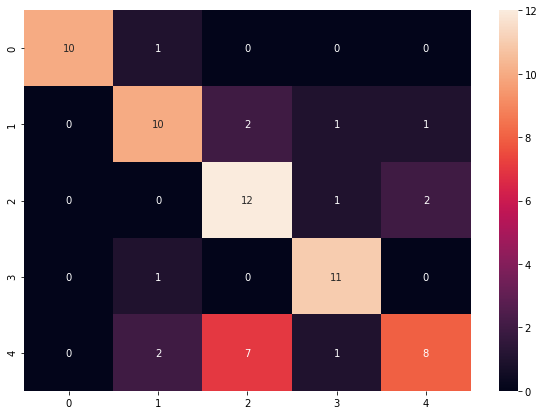

In [87]:
import seaborn as sn
test_classes = {0:'athlitismos', 1:'diaskedasi-psyxagogia', 2:'eidiseis-mme',
       3:'katastimata-agores', 4:'pliroforiki-diadiktyo'}
results_val = [test_classes[i] for i in np.argmax(temp_pred,axis=1)]
true_val = [test_classes[i] for i in np.argmax(temp_y,axis=1)]
cm = confusion_matrix(true_val,results_val)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)

In [61]:
y_pred_train_T = model_MLP.predict(X_tra)
y_pred_val_T = model_MLP.predict(X_val)

In [90]:
y_pred_test_T = model_MLP.predict(test_features.tocsr())

# Retrieval of most similar document using the Weisfeiler-Lehman subtree kernel.<a id='gk'></a>

Create GraKeL graphs for train and test documents.
We use the tokenized documents that we serialized in the start of the notebook.

**We process only nodes that have text!**

In [4]:
y_train_grakel = []
y_train_grakel_idx = []
print("Creating word co-occurrence networks\n for train data")
word_networks = list()
for idx, doc in tqdm(enumerate(train_data)):
    node_labels = dict()
    tokens_to_ids = dict()
    for token in doc:
        if token not in tokens_to_ids:
            tokens_to_ids[token] = len(tokens_to_ids)
            node_labels[tokens_to_ids[token]] = token
    
    edges = list()
    for i in range(len(doc)-1):
        edges.append((tokens_to_ids[doc[i]], tokens_to_ids[doc[i+1]]))
         
    try:        
        word_networks.append(Graph(edges, node_labels=node_labels))
        y_train_grakel.append(y_train[idx])
        y_train_grakel_idx.append(idx)
    except:
        pass

print("Creating word co-occurrence networks\n for test data")
word_networks_test = list()
test_ids = []
for idx, doc in tqdm(enumerate(test_data)):
    node_labels = dict()
    tokens_to_ids = dict()
    for token in doc:
        if token not in tokens_to_ids:
            tokens_to_ids[token] = len(tokens_to_ids)
            node_labels[tokens_to_ids[token]] = token
    
    edges = list()
    for i in range(len(doc)-1):
        edges.append((tokens_to_ids[doc[i]], tokens_to_ids[doc[i+1]]))
         
    try:        
        word_networks_test.append(Graph(edges, node_labels=node_labels))
        test_ids.append(idx)
    except:
        pass

Creating word co-occurrence networks
 for train data


800it [00:46, 17.18it/s]


Creating word co-occurrence networks
 for test data


200it [00:15, 12.55it/s]


This function sums the similarities of the top N (20 in our case) closest documents for each class.

In [28]:
# correct solution:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    
    return e_x / e_x.sum(axis=0)

def get_categories_prob(K, y_train_grakel, idx):
    K[idx, 0] = 0
    similarity_values = np.take(K[:, 0], np.argsort(K[:,0])[-20:]) # 1x10
    similarity_category = np.take(y_train_grakel, np.argsort(K[:,0])[-20:], axis=0) # 10x5+
    
    for idx, similarity in enumerate(similarity_values):
        
        similarity_category[idx] = similarity_category[idx] * similarity

    similarity_category = np.array(np.sum(similarity_category, axis=0))
       
    category_prob = softmax(similarity_category)
    
    return similarity_category, category_prob

In [ ]:
"""gk = WeisfeilerLehman(niter=2, normalize=True, base_kernel=VertexHistogram)
#gk = GraphKernel(kernel = [{"name": "weisfeiler_lehman", "niter": 5}, {"name": "subtree_wl"}], Nystroem=20)

# Train documents
serialized_docs_train_dir = 'C:/Users/User/Desktop/DS_challenge/data/serialized_objects/WL_results/train/'
results_train = []
for idx, train_graph in tqdm(enumerate(word_networks)):
    gk.fit([train_graph])
    K = gk.transform(word_networks)    
    cat_sum, cat_prob = get_categories_prob(K, y_train_grakel, idx)    
        
    res = {
        'doc_id': y_train_grakel_idx[idx],
        'y': y_train_grakel[idx],
        'cat_sum': cat_sum,
        'cat_prob': cat_prob
    }
    print()
    print(res)
        
    pickle_out = open(serialized_docs_train_dir + 'dict.pickle_' + str(idx),"wb")
    pickle.dump(res, pickle_out)
    pickle_out.close()
    
    results_train.append(res)
    
# Test documents
serialized_docs_test_dir = 'C:/Users/User/Desktop/DS_challenge/data/serialized_objects/WL_results/test/'
results_test = []
for idx, test_graph in tqdm(enumerate(word_networks_test)):
    gk.fit([test_graph])
    K = gk.transform(word_networks)
    
    cat_sum, cat_prob = get_categories_prob(K, y_train_grakel)
    res = {
        'doc_id': test_ids[idx],
        'true': y_test[test_ids[idx]],
        'cat_sum': cat_sum,
        'cat_prob': cat_prob
    }
    
    pickle_out = open(serialized_docs_test_dir + 'dict.pickle_' + str(idx),"wb")
    pickle.dump(res, pickle_out)
    pickle_out.close()

    results_test.append(res)

# MEMORY OVERLOAD
# from grakel import GraphKernel
# gk = WeisfeilerLehman(niter=2, normalize=True, base_kernel=VertexHistogram, n_jobs=-1)
# #gk = GraphKernel(kernel = [{"name": "weisfeiler_lehman", "niter": 5}, {"name": "subtree_wl"}], Nystroem=20)


# Κ = gk.fit_transform(word_networks)
# K = gk.transform(word_networks_test)  
"""

Load the WL results calculates above

In [3]:
import os
import pickle
serialized_docs_test_WL_results_dir = 'C:/Users/User/Desktop/DS_challenge/data/serialized_objects/WL_results/train/'
filenames = os.listdir(serialized_docs_test_WL_results_dir)

train_results = []
for file in filenames:
    with open(serialized_docs_test_WL_results_dir + file, 'rb') as file:
        doc = pickle.load(file)
        train_results.append(doc)              

serialized_docs_test_WL_results_dir = 'C:/Users/User/Desktop/DS_challenge/data/serialized_objects/WL_results/test/'
filenames = os.listdir(serialized_docs_test_WL_results_dir)

test_results = []
for file in filenames:
    with open(serialized_docs_test_WL_results_dir + file, 'rb') as file:
        doc = pickle.load(file)
        test_results.append(doc)              

### WL Models

In [6]:
import numpy as np

x_train = []
y_train_class = []
y_train_dum = []
train_probs = []
for doc in train_results:
    x_train.append(doc['cat_sum'])
    train_probs.append(doc['cat_prob'])
    y_train_class.append(np.where(doc['y']==1)[0][0])
    y_train_dum.append(doc['y'])
    
x_test = np.zeros((200,5))
x_test_prob = np.zeros((200,5))
for doc in test_results:
    x_test[doc['doc_id']] = doc['cat_sum']
    x_test_prob[doc['doc_id']] = doc['cat_prob']

In [7]:
print(log_loss(y_train_class, train_probs))

NameError: name 'log_loss' is not defined

In [8]:
x_indicies = list(range(0, 675))
X_tra, X_val, y_tra, y_val = train_test_split(x_indicies, y_train_class, train_size=0.90, random_state=3, stratify=y_train_class)

NameError: name 'train_test_split' is not defined

In [215]:
X_tra_WL = np.take(x_train, X_tra, axis=0)
X_val_WL = np.take(x_train, X_val, axis=0)

y_tra_WL = np.take(y_train_dum ,X_tra, axis=0)
y_val_WL = np.take(y_train_dum ,X_val, axis=0)

In [216]:
svc = SVC(probability=True, C=1, kernel='rbf', gamma=0.0038, random_state=2
         )
svc.fit(X_tra_WL, y_tra)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0038, kernel='rbf',
  max_iter=-1, probability=True, random_state=2, shrinking=True, tol=0.001,
  verbose=False)

In [217]:
y_pred_train_WL = svc.predict_proba(X_tra_WL)
y_pred_val_WL = svc.predict_proba(X_val_WL)

In [218]:
print('WL res:')
print(log_loss(y_tra_WL, y_pred_train_WL))
print(log_loss(y_val_WL, y_pred_val_WL))

WL res:
0.19232843395578017
0.18366625487638547


In [219]:
y_pred_WL = svc.predict_proba(x_test)